# Active Learning Notebook

Use the large data set with active learning.

In [2]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do, merge_with
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence
from active import gsx_query, gsy_query, igs_query, multiple_rounds, three_way_split, flatten

import dask.array as da

## Load the data

In [3]:
x_data = da.from_zarr("./x_data.zarr")
y_data = np.load("./y_data_large.npy")

In [4]:
x_data_np = np.array(x_data)
x_data_np.shape

(8900, 132651)

In [5]:
y_data.shape

(8900, 1)

## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [6]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], 51, 51,51)
        )),    
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=10, correlations=[(0, 0)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3))
    )

In [7]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor),
    ))

def make_linear_model():
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))

def pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [8]:
@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

## Helper Functions

In [9]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

## Set up the active learners

One is a GPR using the maximum std and the other is random

In [19]:
from active import make_igs, make_gsx, make_gsy, make_bayes, make_uncertainty, make_ensemble, make_random

distance_transformer = lambda x: pca_model().fit_transform(x)


def make_learners(x_train, y_train):
    return dict(
#        uncertainty=make_uncertainty(make_gp_model, x_train, y_train),
        random=make_random(make_gp_model, x_train, y_train),
#        ensemble=make_ensemble(x_train, y_train),
#        bayes=make_bayes(make_gp_model, x_train, y_train),
        gsx=make_gsx(distance_transformer)(make_gp_model, x_train, y_train),
        gsy=make_gsy(make_gp_model, x_train, y_train),
        igs=make_igs(distance_transformer)(make_gp_model, x_train, y_train)
    )

## Check the data

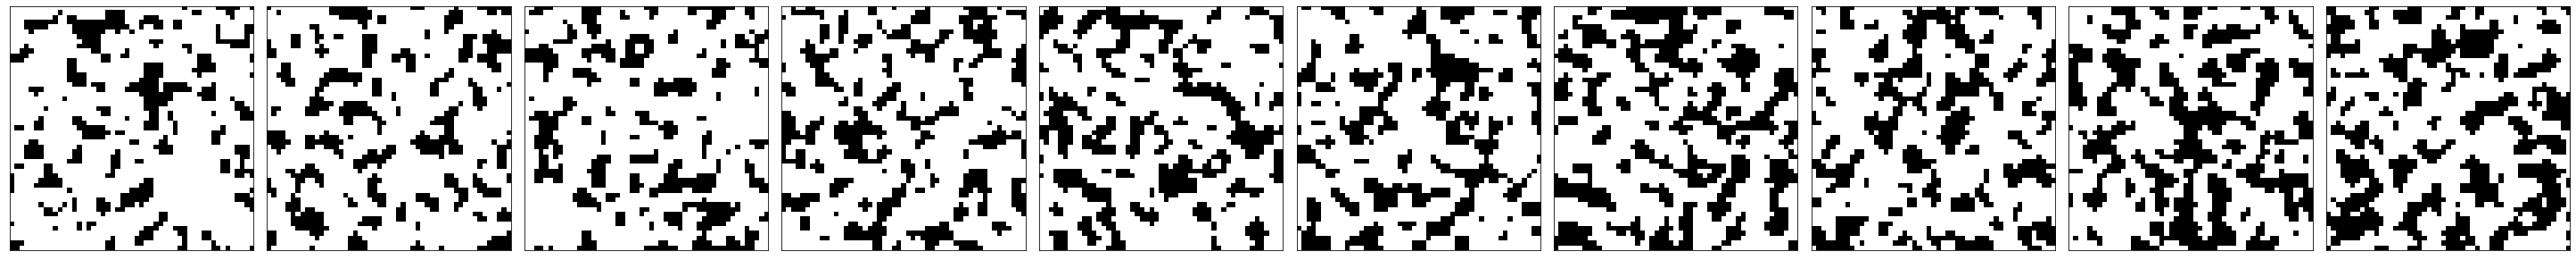

In [10]:
plot_microstructures(*x_data_np[:10].reshape(10, 51, 51, 51)[:, :, :, 0], cmap='gray', colorbar=False);

In [11]:
n_use = 1000

x_pool, x_test, x_train, y_pool, y_test, y_train = three_way_split(x_data_np[:n_use], y_data[:n_use], (0.8, 0.17), None)

In [12]:
print(x_pool.shape)
print(x_test.shape)
print(x_train.shape)

(800, 132651)
(170, 132651)
(30, 132651)


## Test the model

In [13]:
model = make_linear_model()

In [14]:
model.fit(x_pool, y_pool)

Pipeline(steps=[('reshape',
                 GenericTransformer(func=<function pca_steps.<locals>.<lambda> at 0x7f4534341310>)),
                ('discritize', PrimitiveTransformer()),
                ('correlations',
                 TwoPointCorrelation(correlations=[(0, 0)], cutoff=10)),
                ('flatten',
                 GenericTransformer(func=<function pca_steps.<locals>.<lambda> at 0x7f45343410d0>)),
                ('pca', IncrementalPCA(n_components=3)),
                ('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression())])

In [15]:
y_pool_predict = model.predict(x_pool)

In [16]:
y_test_predict = model.predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

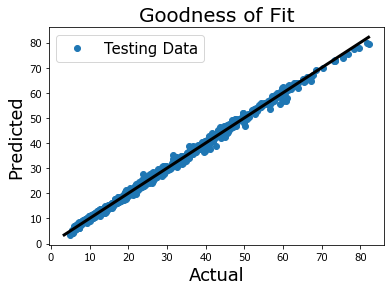

In [17]:
plot_parity(y_pool, y_pool_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

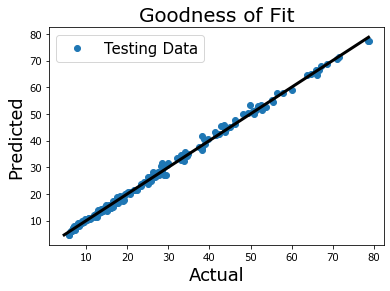

In [18]:
plot_parity(y_test, y_test_predict)

## Test the learners by hand

In [40]:
query_random = lambda model, x_: pipe(
    np.random.randint(0, len(x_)),
    lambda i: (i, x_[i])
)

learner = ActiveLearner(
    estimator=make_gp_model(),
    query_strategy=query_random,
    X_training=x_train,
    y_training=y_train
)

In [41]:
out = learner.query(x_pool)

In [46]:
out1 = oracle_func(x_data, y_data, out)

In [47]:
out1

(array([[1., 0., 0., ..., 1., 1., 1.]]), array([7.06778691]))

## Run the learners

In [38]:
scores = multiple_rounds(x_data_np[:n_use], flatten(y_data[:n_use]), 1, 10, make_learners, oracle_func, (0.8, 0.17))

evaluating random


 10%|█         | 1/10 [00:00<00:00, 249.71it/s]


ValueError: the dimensions of the new training data and label mustagree with the training data and labels provided so far

In [96]:
scores = multiple_rounds(x_data, y_data, 10, 100)

evaluating std


100%|██████████| 100/100 [1:17:36<00:00, 46.57s/it]   


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]



## The results

(0.0, 1.0)

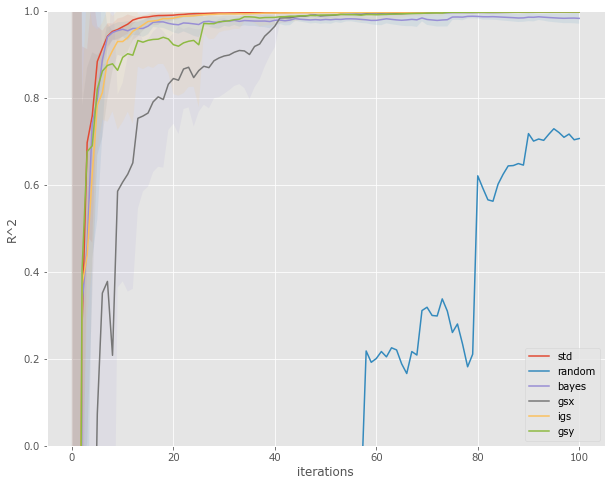

In [98]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0., 1)

(0.9, 1.0)

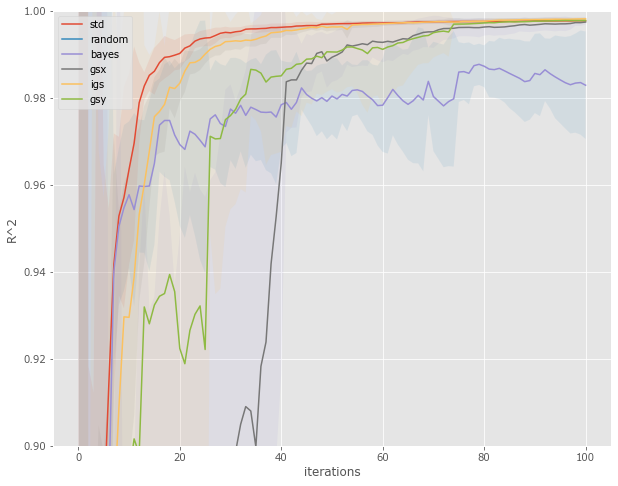

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.9, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

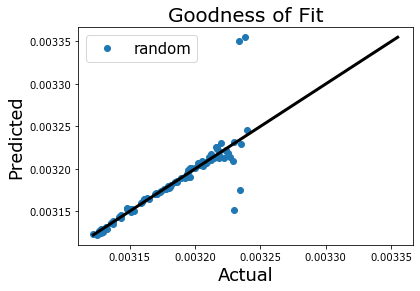

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

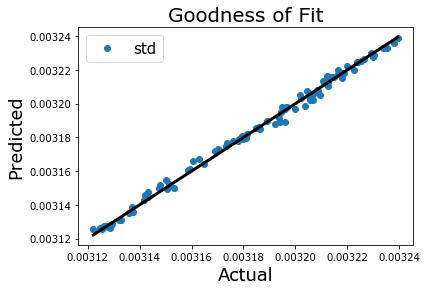

In [90]:
plot_parity(y_test, y_pred_std, label='std')